# Feature Selection

In [2]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn


import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

pd.set_option('display.max_columns', 100)


In [3]:
plyr_logs = pd.read_csv('player_logs_corrected.csv', index_col = 0)
team_logs = pd.read_csv('team_logs_full.csv', index_col = 0)

In [4]:
pl_stat_cols = list(plyr_logs.loc[:,'wl':'days_off'].columns)
plyrs_played = plyr_logs.loc[plyr_logs.mp > 0].groupby(['season','player_name']).filter(lambda x: len(x) >= 20)
plyr_avgs = plyrs_played.groupby(['season','player_name']).mean()[pl_stat_cols].reset_index()

### Cluster NBA Players

There are several different types of NBA players that play certain roles for their teams. The traditional positions of Point Guard, Shooting Guard, Small Forward, Power Forward, and Center do not hold as much weight anymore. I personally can split up players into 7 or 8 different categories, and this varies depending on who you talk to. 

To remove the subjectivity, K-means clustering and Principal Component Analysis will help us find the optimal number of categories and then we can classify each player. This will make the model to predict fantasy scores more accurate, as different player types will rely more heavily on different statistics for their performance. 

Number of Features = 33


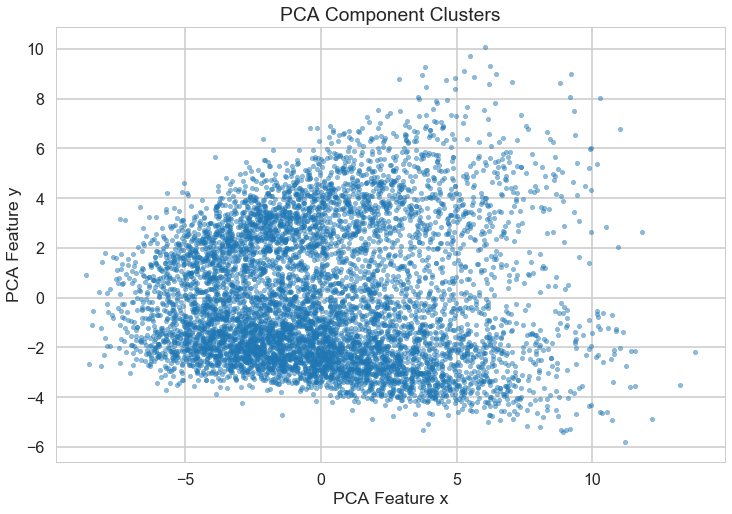

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
X = plyr_avgs.loc[:,'wl':]
print('Number of Features = %d' % len(X.columns))

scaler = StandardScaler()
pca = PCA(n_components = 2, random_state = 1)

pipeline = make_pipeline(scaler,pca)

pca_features = pipeline.fit_transform(X)

x = pca_features[:,0]
y = pca_features[:,1]

fig, ax = plt.subplots()
fig.set_size_inches(12,8)
ax.scatter(x, y, alpha = .5, s = 20)

ax.set_title('PCA Component Clusters')
ax.set_xlabel('PCA Feature x')
ax.set_ylabel('PCA Feature y')
plt.show()

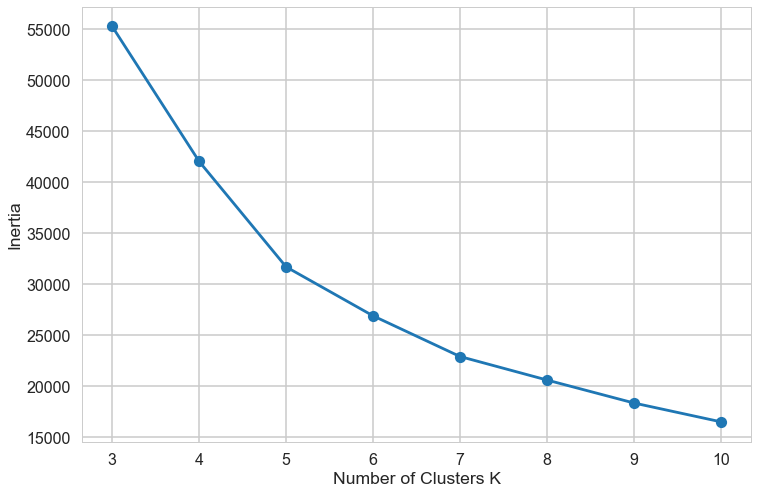

In [6]:
from sklearn.cluster import KMeans
#Create feature and target arrays

X_pca = pca_features
k_vals = range(3,11)
ss_vals = []

for k in k_vals:
    kmeans = KMeans(n_clusters=k, random_state = 1)
    kmeans.fit(X_pca)
    ss_vals.append(kmeans.inertia_)

fig, ax1 = plt.subplots()
fig.set_size_inches(12,8)

ax1.plot(k_vals, ss_vals, marker = 'o')
ax1.set_xlabel('Number of Clusters K')
ax1.set_ylabel('Inertia')
ax1.set_xticks(k_vals)
plt.show()

In [7]:
from sklearn.metrics import silhouette_samples, silhouette_score

def get_sil_score(X, k):
    kmeans = KMeans(n_clusters = k, random_state=1)
    labels = kmeans.fit_predict(X)
    return silhouette_score(X, labels)

sil_scores = {k: get_sil_score(X_pca,k) for k in k_vals}
for x in sil_scores:
    print('# Clusters: %d' % x, '     Silhouette score: %f' % sil_scores[x])

# Clusters: 3      Silhouette score: 0.416406
# Clusters: 4      Silhouette score: 0.373320
# Clusters: 5      Silhouette score: 0.386753
# Clusters: 6      Silhouette score: 0.362311
# Clusters: 7      Silhouette score: 0.359362
# Clusters: 8      Silhouette score: 0.346236
# Clusters: 9      Silhouette score: 0.357240
# Clusters: 10      Silhouette score: 0.348692


In [8]:
k = 9
kmeans = KMeans(n_clusters = k, random_state=1)
plyr_avgs['cluster'] = kmeans.fit_predict(X_pca)
get_sil_score(X_pca, k)

0.3572397690491344

In [9]:
kmeans.cluster_centers_[0]

array([-1.07078786, -1.73541002])

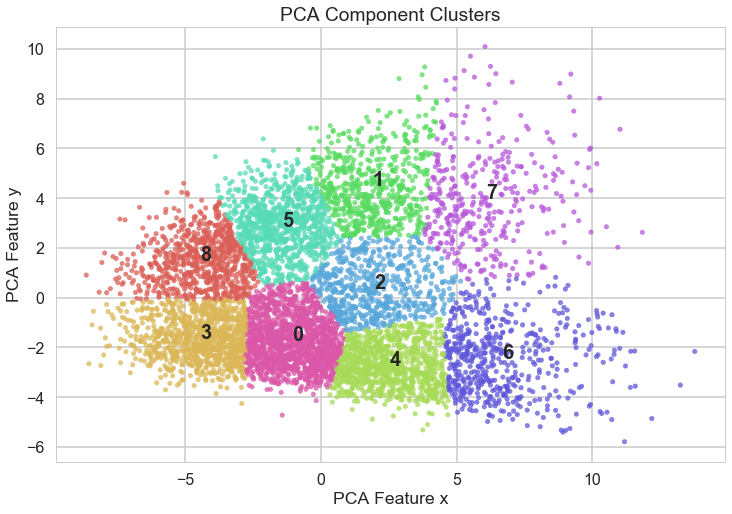

In [10]:
x = pca_features[:,0]
y = pca_features[:,1]
centers = kmeans.cluster_centers_

color_labels = plyr_avgs['cluster'].unique()
rgb_values = sns.color_palette("hls", 9)
color_map = dict(zip(color_labels, rgb_values))

fig, ax = plt.subplots()
fig.set_size_inches(12,8)
ax.scatter(x, y, alpha = .75, s = 20, c=plyr_avgs.cluster.map(color_map))

for x in range(k):
    ax.annotate(str(x), 
        xy = centers[x],
        size=20, weight='bold') 

ax.set_title('PCA Component Clusters')
ax.set_xlabel('PCA Feature x')
ax.set_ylabel('PCA Feature y')
plt.show()

In [11]:
pd.DataFrame(pca.components_,columns=X.columns,index = ['PC-1','PC-2'])

,wl,mp,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus,fscore,ast_pct,blk_pct,dreb_pct,oreb_pct,reb_pct,stl_pct,tov_pct,efg_pct,ts_pct,usg_pct,days_off
PC-1,0.027144,0.255133,0.259274,0.253557,0.181191,0.125482,0.127177,0.099066,0.236046,0.235662,0.240605,0.118348,0.202919,0.185549,0.176466,0.199001,0.102098,0.236282,0.174647,0.260852,0.091025,0.267705,0.110184,0.005322,0.044980,-0.020169,0.020197,0.047360,-0.022354,0.189597,0.204265,0.173936,-0.167842
PC-2,-0.006560,-0.027683,-0.022793,-0.068739,0.153573,-0.239182,-0.247383,-0.270231,-0.008598,0.029339,-0.022898,0.300022,0.197315,0.242909,-0.175738,-0.102884,0.262350,-0.049625,0.149199,-0.046742,-0.000615,0.011467,-0.205951,0.274284,0.304495,0.321294,0.338830,-0.114824,0.036865,0.044846,0.039262,-0.075338,-0.003397


In [12]:
clust_avgs = plyr_avgs.groupby('cluster').mean().reset_index()
clust_avgs.sort_values('fscore', ascending = False)

,cluster,season,wl,mp,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus,fscore,ast_pct,blk_pct,dreb_pct,oreb_pct,reb_pct,stl_pct,tov_pct,efg_pct,ts_pct,usg_pct,days_off
6,6,2008.345936,0.548598,36.429432,7.450526,16.544176,0.448119,1.557569,4.289765,0.318139,4.684579,5.724348,0.753593,0.990821,4.059912,5.050765,5.327511,1.395484,0.423190,2.774219,2.362519,21.143201,2.039375,38.775728,25.980451,0.926010,12.777046,3.069023,7.923073,2.001178,12.960270,0.495917,0.552005,27.164024,2.119581
7,7,2008.502703,0.539680,34.633028,7.015401,13.947646,0.507147,0.285123,0.853507,0.094842,3.973689,5.457235,0.669072,2.669048,7.084960,9.754008,2.543137,0.960453,1.366054,2.265758,2.875196,18.289613,1.869735,38.678510,13.017828,3.125779,23.430670,8.736118,16.083394,1.447334,12.462415,0.517014,0.559714,24.528508,2.113538
4,4,2009.196670,0.494460,30.445934,4.760761,11.037167,0.421152,1.377356,3.730305,0.318802,2.231585,2.760708,0.578543,0.607096,2.703309,3.310405,3.879569,1.057276,0.233876,1.840397,2.140680,13.130464,0.262554,25.516429,20.787312,0.606111,10.153456,2.254383,6.203917,1.814638,13.357405,0.483704,0.524815,21.118647,2.118639
1,1,2008.381849,0.492924,26.656347,3.963554,7.812669,0.503376,0.047269,0.162650,0.024709,1.938602,2.842422,0.503073,2.490567,5.125341,7.615908,1.230455,0.652079,1.169965,1.447474,2.798405,9.912978,0.008288,24.521193,7.457253,3.426280,21.746098,10.571635,16.158866,1.278772,14.470315,0.505898,0.540942,18.042102,2.124245
2,2,2009.095400,0.490547,28.342264,4.435374,9.710167,0.446242,0.789837,2.259298,0.232691,2.007262,2.657991,0.528179,1.370309,3.904604,5.274913,1.926600,0.893478,0.551830,1.493400,2.395350,11.667848,0.021333,23.809950,10.934013,1.541256,15.830433,5.536956,10.683695,1.641152,12.381652,0.487346,0.525656,19.893449,2.116429
0,0,2009.258087,0.482989,20.772115,2.662046,6.376618,0.387854,0.827163,2.322471,0.257575,1.056916,1.369888,0.360126,0.505925,1.985384,2.491309,1.929827,0.672862,0.208506,1.055035,1.723658,7.208172,-0.605717,14.878808,14.540018,0.796568,10.907376,2.811902,6.859630,1.675032,13.421030,0.448885,0.482596,17.828572,2.184611
5,5,2008.280447,0.466457,17.876152,2.281421,4.700162,0.445613,0.053225,0.187778,0.027612,1.067678,1.605037,0.347328,1.541006,2.935112,4.476117,0.732230,0.470044,0.667180,0.899622,2.238299,5.683745,-0.745039,14.284601,6.278461,2.912279,18.880070,9.913518,14.396781,1.337233,14.913545,0.450267,0.487575,16.302102,2.224217
8,8,2007.464000,0.479951,10.834533,1.171171,2.651443,0.338906,0.055591,0.202330,0.030339,0.545694,0.847073,0.208124,0.843480,1.589153,2.432633,0.423474,0.274029,0.347807,0.539795,1.488732,2.943627,-0.942743,7.630141,5.263025,2.466923,16.982359,9.051850,13.017097,1.245292,14.339003,0.346006,0.386670,15.481247,2.569830
3,3,2008.846233,0.497968,11.530207,1.259856,3.254709,0.299101,0.370889,1.152164,0.157147,0.487538,0.667438,0.192574,0.299743,1.064120,1.363863,1.004326,0.371435,0.112709,0.596582,1.081123,3.378137,-0.903705,7.447223,12.841813,0.754206,10.493653,2.970844,6.732248,1.632958,13.307268,0.342657,0.375501,16.868424,2.538565


In [13]:
counting_stats = ['mp','pts','ast','reb','stl','blk','tov','fscore']
clust_avgs[['cluster']+counting_stats].sort_values('fscore', ascending = False)

,cluster,mp,pts,ast,reb,stl,blk,tov,fscore
6,6,36.429432,21.143201,5.327511,5.050765,1.395484,0.423190,2.774219,38.775728
7,7,34.633028,18.289613,2.543137,9.754008,0.960453,1.366054,2.265758,38.678510
4,4,30.445934,13.130464,3.879569,3.310405,1.057276,0.233876,1.840397,25.516429
1,1,26.656347,9.912978,1.230455,7.615908,0.652079,1.169965,1.447474,24.521193
2,2,28.342264,11.667848,1.926600,5.274913,0.893478,0.551830,1.493400,23.809950
0,0,20.772115,7.208172,1.929827,2.491309,0.672862,0.208506,1.055035,14.878808
5,5,17.876152,5.683745,0.732230,4.476117,0.470044,0.667180,0.899622,14.284601
8,8,10.834533,2.943627,0.423474,2.432633,0.274029,0.347807,0.539795,7.630141
3,3,11.530207,3.378137,1.004326,1.363863,0.371435,0.112709,0.596582,7.447223


In [14]:
plyr_avgs[plyr_avgs.cluster == 0].sort_values('pts', ascending = False)

,season,player_name,wl,mp,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus,fscore,ast_pct,blk_pct,dreb_pct,oreb_pct,reb_pct,stl_pct,tov_pct,efg_pct,ts_pct,usg_pct,days_off,cluster
671,2001,Ron Mercer,0.264151,32.377358,5.867925,14.792453,0.350321,0.339623,1.169811,0.130491,1.792453,2.245283,0.487415,0.943396,2.415094,3.358491,2.415094,0.603774,0.245283,1.660377,2.037736,13.867925,-6.754717,22.726415,14.088766,0.576080,9.017089,3.401257,6.209173,0.919732,9.504763,0.359174,0.393508,23.367473,2.264151,0
4243,2011,Anthony Morrow,0.322581,26.354839,4.387097,10.612903,0.385339,1.709677,4.612903,0.308935,1.564516,1.677419,0.505661,0.500000,1.548387,2.048387,0.983871,0.741935,0.145161,1.129032,1.387097,12.048387,-1.483871,18.149194,7.187830,0.425913,6.726546,2.193526,4.460036,1.614298,8.863626,0.456372,0.495779,21.990671,1.967742,0
3747,2009,Rasual Butler,0.353659,32.963415,4.341463,10.609756,0.393854,1.768293,5.268293,0.314817,1.487805,1.768293,0.525220,0.475610,2.451220,2.926829,1.414634,0.439024,0.829268,0.963415,1.475610,11.939024,-3.682927,20.658537,7.147452,1.982024,8.438184,1.706353,5.072268,0.689194,8.459036,0.468884,0.499277,16.899463,2.073171,0
1844,2004,Tony Delk,0.107143,23.946429,4.392857,10.553571,0.389268,1.285714,3.607143,0.285804,1.839286,2.428571,0.489411,0.500000,1.821429,2.321429,1.857143,0.839286,0.053571,0.964286,2.196429,11.910714,-3.839286,19.544643,13.495476,0.131568,8.726601,2.165244,5.445923,1.931983,8.167452,0.445051,0.479861,24.096050,2.196429,0
6209,2015,Sean Kilpatrick,0.241379,21.137931,4.241379,9.310345,0.442483,1.344828,3.931034,0.319241,2.068966,2.310345,0.630448,0.413793,1.517241,1.931034,1.000000,0.413793,0.068966,1.068966,1.275862,11.896552,-4.931034,16.913793,7.104035,0.191816,7.650909,2.559167,5.105038,1.017300,10.197724,0.520014,0.563672,22.696865,2.068966,0
2278,2006,Adam Morrison,0.384615,29.871795,4.551282,12.102564,0.355269,1.115385,3.307692,0.307782,1.538462,2.166667,0.443231,0.692308,2.256410,2.948718,2.089744,0.358974,0.076923,1.666667,2.294872,11.756410,-3.038462,19.173077,12.250151,0.168605,8.881718,3.729042,6.305380,0.615564,12.269688,0.400140,0.423739,22.574218,2.064103,0
5327,2013,O.J. Mayo,0.192308,25.903846,4.307692,10.576923,0.362538,1.615385,4.365385,0.295000,1.461538,1.692308,0.506404,0.461538,1.923077,2.384615,2.173077,0.538462,0.250000,1.826923,2.134615,11.692308,-6.865385,19.403846,13.516167,0.755034,8.794484,1.812021,5.303253,1.052839,14.012559,0.430144,0.460342,22.683066,2.211538,0
4035,2010,Jordan Crawford,0.404762,24.452381,4.571429,11.904762,0.367571,0.785714,3.047619,0.226405,1.738095,2.000000,0.375905,0.738095,1.761905,2.500000,2.785714,0.928571,0.071429,1.976190,1.500000,11.666667,-5.404762,20.517857,16.874218,0.097648,10.049498,3.341698,6.695598,1.751737,13.319619,0.408761,0.432612,26.493084,2.404762,0
4542,2011,Richard Hamilton,0.750000,24.928571,5.000000,11.071429,0.428679,0.607143,1.642857,0.280929,1.035714,1.321429,0.377286,0.714286,1.642857,2.357143,3.000000,0.428571,0.035714,1.750000,2.000000,11.642857,4.178571,19.500000,20.427049,0.148693,6.660512,2.859770,4.760141,0.861475,12.706855,0.453925,0.476985,23.672987,2.392857,0
5827,2014,Tim Hardaway Jr.,0.228571,24.042857,3.985714,10.242857,0.378071,1.728571,5.057143,0.304157,1.785714,2.228571,0.594000,0.171429,2.057143,2.228571,1.814286,0.285714,0.200000,1.171429,1.700000,11.485714,-5.042857,18.242857,12.707190,0.576707,9.672099,0.728154,5.200126,0.958853,8.916958,0.456380,0.500115,23.839449,2.142857,0


In [15]:
recent = plyr_avgs.loc[(plyr_avgs.season >= 2013)]
top10_fs_clust = recent.groupby(['cluster']).fscore.nlargest(10).reset_index().set_index('level_1')
top10_fs_clust_df = recent[['season','player_name']].join(top10_fs_clust, how = 'inner')
top10_fs_clust_df.pivot(columns='cluster')['player_name'].apply(lambda x: pd.Series(x.dropna().values))

cluster,0,1,2,3,4,5,6,7,8
0,Caron Butler,Marcin Gortat,Josh Smith,Beno Udrih,Brandon Jennings,Al-Farouq Aminu,Kevin Durant,Kevin Love,Andrew Nicholson
1,Jarrett Jack,Nikola Vucevic,Nicolas Batum,Luke Ridnour,Jrue Holiday,Glen Davis,Russell Westbrook,Anthony Davis,Ekpe Udoh
2,Steve Blake,Al Horford,Thaddeus Young,Cleanthony Early,Rajon Rondo,Jason Smith,Russell Westbrook,DeMarcus Cousins,Jon Leuer
3,Jose Calderon,Al Jefferson,Draymond Green,Ish Smith,Jrue Holiday,Kevin Garnett,Stephen Curry,DeMarcus Cousins,Anthony Bennett
4,Lance Stephenson,Brook Lopez,Al Horford,Kostas Papanikolaou,Kemba Walker,Kris Humphries,James Harden,Anthony Davis,Brandon Davies
5,Norris Cole,Marcin Gortat,Al Horford,Spencer Dinwiddie,Ricky Rubio,Zaza Pachulia,LeBron James,DeMarcus Cousins,Drew Gooden
6,Raymond Felton,Thaddeus Young,Draymond Green,Phil Pressey,Ty Lawson,Cody Zeller,Russell Westbrook,Karl-Anthony Towns,Robert Sacre
7,Ish Smith,Nikola Vucevic,Aaron Gordon,Sasha Vujacic,Tyreke Evans,Kevin Garnett,James Harden,Anthony Davis,Shawn Marion
8,T.J. McConnell,Enes Kanter,Al Horford,Paul Zipser,Jrue Holiday,Joakim Noah,LeBron James,DeMarcus Cousins,Kevin Garnett
9,Tyreke Evans,Hassan Whiteside,Draymond Green,Tim Frazier,Lonzo Ball,Larry Nance Jr.,Russell Westbrook,Giannis Antetokounmpo,Kyle Collinsworth


## Cluster Analysis

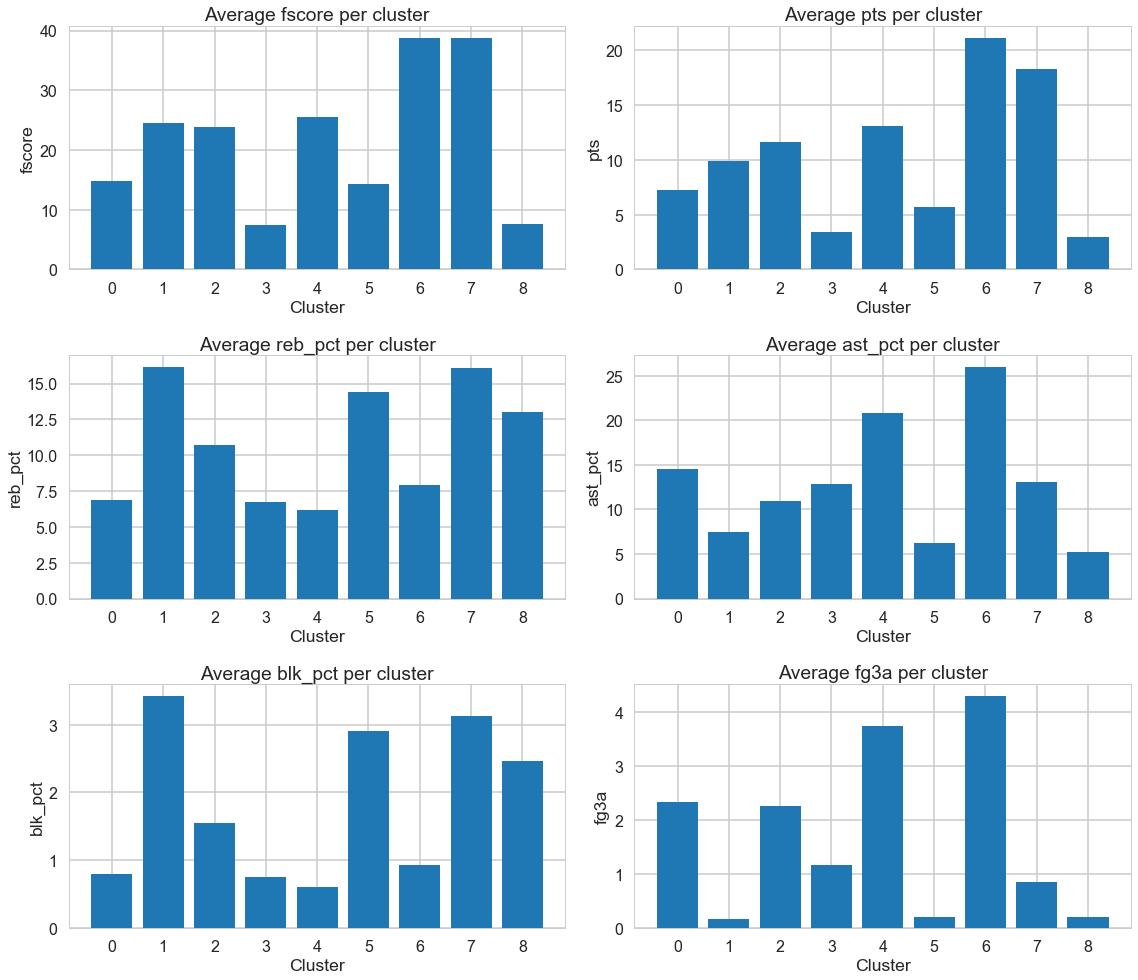

In [16]:
plot_stats = ['fscore','pts','reb_pct','ast_pct','blk_pct','fg3a']
plt.figure(figsize=(16,14))

for i,stat in enumerate(plot_stats):
    plt.subplot(3,2,i+1)
    plt.bar(clust_avgs.cluster, clust_avgs[stat])
    plt.xticks(range(9))
    plt.ylabel(stat)
    plt.xlabel('Cluster')
    plt.title('Average '+stat+' per cluster')

plt.tight_layout()
plt.show()

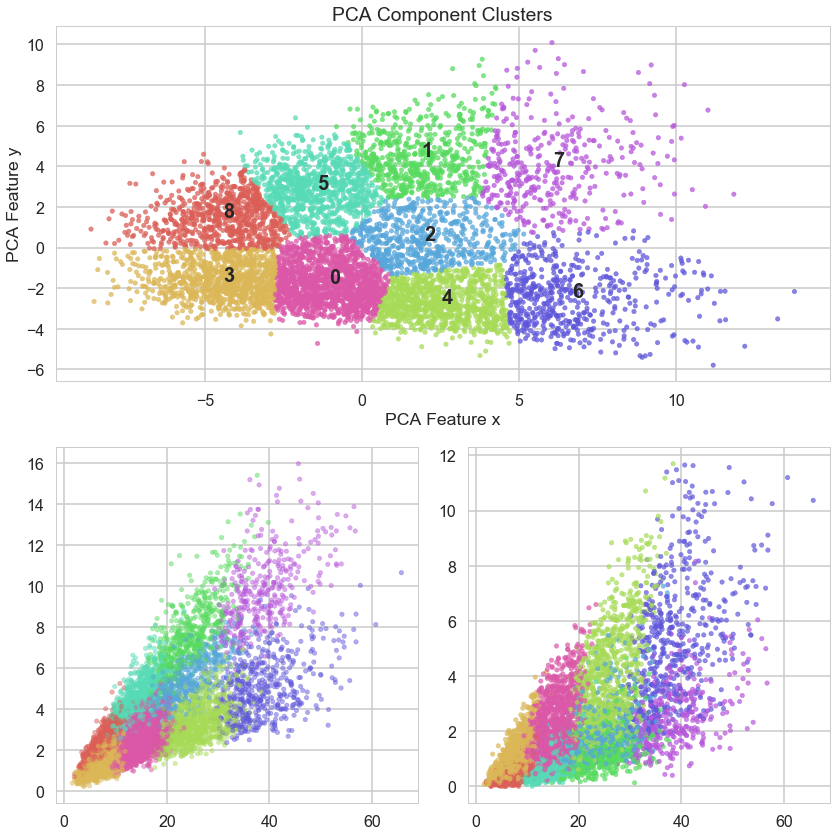

In [17]:
x = pca_features[:,0]
y = pca_features[:,1]
plt.figure(figsize=(12,12))


ax = plt.subplot2grid((2,2), (0, 0), colspan=2)
ax.scatter(x, y, alpha = .75, s = 20, c=plyr_avgs.cluster.map(color_map))

for x in range(k):
    ax.annotate(str(x), 
        xy = centers[x],
        size=20, weight='bold') 

ax.set_title('PCA Component Clusters')
ax.set_xlabel('PCA Feature x')
ax.set_ylabel('PCA Feature y')


ax1 = plt.subplot2grid((2,2), (1, 0))
ax1.scatter(plyr_avgs.fscore, plyr_avgs.reb, c=plyr_avgs.cluster.map(color_map), s = 20, alpha = .5)

ax2 = plt.subplot2grid((2,2), (1, 1))
ax2.scatter(plyr_avgs.fscore, plyr_avgs.ast, c=plyr_avgs.cluster.map(color_map), s = 20, alpha = .7)


plt.tight_layout()
plt.show()

In [18]:
last8gms = plyr_logs.groupby('player_name').rolling(8).mean()
expanding = plyr_logs.groupby('player_name').expanding(1).mean()
last8gms = last8gms.fillna(expanding).sort_values('game_date').reset_index(drop=True)
last8gms.head()

,game_date,year,month,day,season_id,season,player_id,player_name,team_id,team_abbreviation,team_name,team,opp,game_id,home,matchup,wl,mp,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus,fscore,ast_pct,blk_pct,dreb_pct,oreb_pct,reb_pct,stl_pct,tov_pct,efg_pct,ts_pct,usg_pct,days_off,game_count
0,2000-10-31,2000.0,10.0,31.0,22000.0,2000.0,1740.0,Rashard Lewis,1.610613e+09,SEA,Seattle SuperSonics,OKC,MEM,20000013.0,0.0,SEA @ VAN,0.0,35.0,3.0,10.0,0.30,2.0,5.0,0.4,3.0,4.0,0.750,1.0,4.0,5.0,1.0,1.0,0.0,3.0,5.0,11.0,-4.0,20.25,4.941562,0.000000,10.593407,2.648352,6.620879,1.422374,20.325203,0.40,0.467687,18.039251,4.0,1.0
1,2000-10-31,2000.0,10.0,31.0,22000.0,2000.0,435.0,Carlos Rogers,1.610613e+09,HOU,Houston Rockets,HOU,MIN,20000008.0,1.0,HOU vs. MIN,0.0,8.0,0.0,0.0,0.00,0.0,0.0,0.0,1.0,2.0,0.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-14.0,1.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.568182,4.817518,4.0,1.0
2,2000-10-31,2000.0,10.0,31.0,22000.0,2000.0,949.0,Shareef Abdur-Rahim,1.610613e+09,VAN,Vancouver Grizzlies,MEM,OKC,20000013.0,1.0,VAN vs. SEA,1.0,42.0,12.0,16.0,0.75,0.0,1.0,0.0,3.0,6.0,0.500,1.0,6.0,7.0,7.0,3.0,1.0,6.0,3.0,27.0,3.0,51.25,31.842205,1.510025,13.501401,2.250233,7.875817,3.570688,24.350649,0.75,0.724249,25.148820,4.0,1.0
3,2000-10-31,2000.0,10.0,31.0,22000.0,2000.0,735.0,Bryant Reeves,1.610613e+09,VAN,Vancouver Grizzlies,MEM,OKC,20000013.0,1.0,VAN vs. SEA,1.0,33.0,1.0,4.0,0.25,0.0,0.0,0.0,2.0,6.0,0.333,1.0,11.0,12.0,0.0,1.0,1.0,1.0,2.0,4.0,-2.0,22.50,0.000000,1.921850,31.503268,2.863933,17.183601,1.514837,13.089005,0.25,0.301205,9.924431,4.0,1.0
4,2000-10-31,2000.0,10.0,31.0,22000.0,2000.0,1887.0,Wally Szczerbiak,1.610613e+09,MIN,Minnesota Timberwolves,MIN,HOU,20000008.0,0.0,MIN @ HOU,1.0,23.0,2.0,8.0,0.25,0.0,0.0,0.0,0.0,0.0,0.000,2.0,2.0,4.0,5.0,0.0,0.0,2.0,3.0,4.0,6.0,15.50,26.751735,0.000000,9.446640,9.446640,9.446640,0.000000,20.000000,0.25,0.250000,18.886413,4.0,1.0


In [19]:
last8gms_clean = last8gms[(['game_date', 'player_name']+list(last8gms.columns[17:-1]))]
last8gms_clean.columns = ['game_date','player_name']+[x+'_l8' for x in last8gms.columns[17:-1]]             
last8gms_clean.head()

,game_date,player_name,mp_l8,fgm_l8,fga_l8,fg_pct_l8,fg3m_l8,fg3a_l8,fg3_pct_l8,ftm_l8,fta_l8,ft_pct_l8,oreb_l8,dreb_l8,reb_l8,ast_l8,stl_l8,blk_l8,tov_l8,pf_l8,pts_l8,plus_minus_l8,fscore_l8,ast_pct_l8,blk_pct_l8,dreb_pct_l8,oreb_pct_l8,reb_pct_l8,stl_pct_l8,tov_pct_l8,efg_pct_l8,ts_pct_l8,usg_pct_l8,days_off_l8
0,2000-10-31,Rashard Lewis,35.0,3.0,10.0,0.30,2.0,5.0,0.4,3.0,4.0,0.750,1.0,4.0,5.0,1.0,1.0,0.0,3.0,5.0,11.0,-4.0,20.25,4.941562,0.000000,10.593407,2.648352,6.620879,1.422374,20.325203,0.40,0.467687,18.039251,4.0
1,2000-10-31,Carlos Rogers,8.0,0.0,0.0,0.00,0.0,0.0,0.0,1.0,2.0,0.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-14.0,1.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.568182,4.817518,4.0
2,2000-10-31,Shareef Abdur-Rahim,42.0,12.0,16.0,0.75,0.0,1.0,0.0,3.0,6.0,0.500,1.0,6.0,7.0,7.0,3.0,1.0,6.0,3.0,27.0,3.0,51.25,31.842205,1.510025,13.501401,2.250233,7.875817,3.570688,24.350649,0.75,0.724249,25.148820,4.0
3,2000-10-31,Bryant Reeves,33.0,1.0,4.0,0.25,0.0,0.0,0.0,2.0,6.0,0.333,1.0,11.0,12.0,0.0,1.0,1.0,1.0,2.0,4.0,-2.0,22.50,0.000000,1.921850,31.503268,2.863933,17.183601,1.514837,13.089005,0.25,0.301205,9.924431,4.0
4,2000-10-31,Wally Szczerbiak,23.0,2.0,8.0,0.25,0.0,0.0,0.0,0.0,0.0,0.000,2.0,2.0,4.0,5.0,0.0,0.0,2.0,3.0,4.0,6.0,15.50,26.751735,0.000000,9.446640,9.446640,9.446640,0.000000,20.000000,0.25,0.250000,18.886413,4.0


In [21]:
last8gms_tm = team_logs.groupby('team').rolling(8).mean()
expanding_tm = team_logs.groupby('team').expanding(1).mean()
last8gms_tm = last8gms_tm.fillna(expanding_tm).sort_values('game_date').reset_index(drop=True)
last8gms_tm_clean = last8gms_tm[(['game_date', 'team']+['pace','off_eff','def_eff','days_off'])]
last8gms_tm_clean.columns = ['game_date','team']+[x+'_l8' for x in last8gms_tm_clean.columns[2:]]             
last8gms_tm_clean.head()


,game_date,team,pace_l8,off_eff_l8,def_eff_l8,days_off_l8
0,2000-10-31,ATL,88.402588,91.218166,117.916165,4.0
1,2000-10-31,CHA,88.402588,121.964129,94.349609,4.0
2,2000-10-31,SAC,91.393504,108.623499,87.985034,4.0
3,2000-10-31,CLE,97.673868,87.728246,83.647863,4.0
4,2000-10-31,TOR,97.413433,97.521101,106.759942,4.0


In [22]:
plyr_logs_l8 = pd.merge(plyrs_played,last8gms_clean, on = ['game_date','player_name'])
plyr_logs_l8.head(10)

,game_date,year,month,day,season_id,season,player_id,player_name,team_id,team_abbreviation,team_name,team,opp,game_id,home,matchup,wl,mp,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus,fscore,ast_pct,blk_pct,dreb_pct,oreb_pct,reb_pct,stl_pct,tov_pct,efg_pct,ts_pct,usg_pct,days_off,game_count,mp_l8,fgm_l8,fga_l8,fg_pct_l8,fg3m_l8,fg3a_l8,fg3_pct_l8,ftm_l8,fta_l8,ft_pct_l8,oreb_l8,dreb_l8,reb_l8,ast_l8,stl_l8,blk_l8,tov_l8,pf_l8,pts_l8,plus_minus_l8,fscore_l8,ast_pct_l8,blk_pct_l8,dreb_pct_l8,oreb_pct_l8,reb_pct_l8,stl_pct_l8,tov_pct_l8,efg_pct_l8,ts_pct_l8,usg_pct_l8,days_off_l8
0,2000-10-31,2000,10,31,22000,2000,672,Matt Bullard,1610612745,HOU,Houston Rockets,HOU,MIN,20000008,1,HOU vs. MIN,0,8,0,1,0.000,0,1,0.000,0,0,0.000,0,1,1.0,0,0,0,1,1,0,-2,0.75,0.000000,0.000000,15.789474,0.000000,7.894737,0.000000,50.000000,0.000000,0.000000,10.948905,4.0,1,8.0,0.0,1.0,0.000,0.0,1.0,0.000,0.0,0.0,0.000,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,-2.0,0.75,0.000000,0.000000,15.789474,0.000000,7.894737,0.000000,50.000000,0.000000,0.000000,10.948905,4.0
1,2000-10-31,2000,10,31,22000,2000,951,Ray Allen,1610612749,MIL,Milwaukee Bucks,MIL,DAL,20000007,0,MIL @ DAL,0,40,8,17,0.471,2,6,0.333,8,8,1.000,2,2,4.0,2,0,0,1,1,26,-9,34.50,10.256410,0.000000,4.705882,4.705882,4.705882,0.000000,4.646840,0.529412,0.633528,22.966916,4.0,1,40.0,8.0,17.0,0.471,2.0,6.0,0.333,8.0,8.0,1.000,2.0,2.0,4.0,2.0,0.0,0.0,1.0,1.0,26.0,-9.0,34.50,10.256410,0.000000,4.705882,4.705882,4.705882,0.000000,4.646840,0.529412,0.633528,22.966916,4.0
2,2000-10-31,2000,10,31,22000,2000,714,Michael Finley,1610612742,DAL,Dallas Mavericks,DAL,MIL,20000007,1,DAL vs. MIL,1,42,10,21,0.476,0,5,0.000,6,8,0.750,3,6,9.0,8,2,0,2,2,26,13,52.25,38.787879,0.000000,13.186813,6.593407,9.890110,2.431909,7.541478,0.476190,0.530179,25.931358,4.0,1,42.0,10.0,21.0,0.476,0.0,5.0,0.000,6.0,8.0,0.750,3.0,6.0,9.0,8.0,2.0,0.0,2.0,2.0,26.0,13.0,52.25,38.787879,0.000000,13.186813,6.593407,9.890110,2.431909,7.541478,0.476190,0.530179,25.931358,4.0
3,2000-10-31,2000,10,31,22000,2000,361,Clifford Robinson,1610612756,PHX,Phoenix Suns,PHX,GSW,20000011,0,PHX @ GSW,0,42,10,25,0.400,2,6,0.333,4,6,0.667,1,4,5.0,3,2,1,1,2,26,-3,43.25,13.953488,1.632653,10.389610,2.597403,6.493506,2.279162,3.491620,0.440000,0.470333,28.265482,4.0,1,42.0,10.0,25.0,0.400,2.0,6.0,0.333,4.0,6.0,0.667,1.0,4.0,5.0,3.0,2.0,1.0,1.0,2.0,26.0,-3.0,43.25,13.953488,1.632653,10.389610,2.597403,6.493506,2.279162,3.491620,0.440000,0.470333,28.265482,4.0
4,2000-10-31,2000,10,31,22000,2000,739,Rasheed Wallace,1610612757,POR,Portland Trail Blazers,POR,LAL,20000012,1,POR vs. LAL,0,47,11,17,0.647,2,2,1.000,2,2,1.000,3,4,7.0,2,0,1,3,1,26,-8,39.25,8.916247,1.374353,12.712766,9.534574,11.123670,0.000000,14.367816,0.705882,0.727069,20.810863,4.0,1,47.0,11.0,17.0,0.647,2.0,2.0,1.000,2.0,2.0,1.000,3.0,4.0,7.0,2.0,0.0,1.0,3.0,1.0,26.0,-8.0,39.25,8.916247,1.374353,12.712766,9.534574,11.123670,0.000000,14.367816,0.705882,0.727069,20.810863,4.0
5,2000-10-31,2000,10,31,22000,2000,1713,Vince Carter,1610612761,TOR,Toronto Raptors,TOR,DET,20000005,1,TOR vs. DET,0,40,9,24,0.375,1,4,0.250,7,10,0.700,1,2,3.0,2,4,0,1,6,26,-7,40.75,9.977230,0.000000,5.020833,2.510417,3.765625,5.098281,3.401361,0.395833,0.457746,29.124466,4.0,1,40.0,9.0,24.0,0.375,1.0,4.0,0.250,7.0,10.0,0.700,1.0,2.0,3.0,2.0,4.0,0.0,1.0,6.0,26.0,-7.0,40.75,9.977230,0.000000,5.020833,2.510417,3.765625,5.098281,3.401361,0.395833,0.457746,29.124466,4.0
6,2000-10-31,2000,10,31,22000,2000,120,Steven Smith,1610612757,POR,Portland Trail Blazers,POR,LAL,20000012,1,POR vs. LAL,0,36,8,18,0.444,0,4,0.000,6,7,0.857,1,1,2.0,5,0,0,1,3,22,-24,31.50,28.398289,0.000000,4.149306,4.149306,4.149306,0.000000,4.528986,0.444444,0.521822,28.731217,4.0,1,36.0,8.0,18.0,0.444,0.0,4.0,0.000,6.0,7.0,0.857,1.0,1.0,2.0,5.0,0.0,0.0,1.0,3.0,22.0,-24.0,31.50,28.398289,0.000000,4.149306,4.149306,4.149306,0.000000,4.528986,0.444444,0.521822,28.731217,4.0
7,2000-10-31,2000,10,31,22000,2000,764,David Robins

In [54]:
last8gms_tm_clean.head()

,game_date,team,pace_l8,off_eff_l8,def_eff_l8,days_off_l8
0,2000-10-31,ATL,88.402588,91.218166,117.916165,4.0
1,2000-10-31,CHA,88.402588,121.964129,94.349609,4.0
2,2000-10-31,SAC,91.393504,108.623499,87.985034,4.0
3,2000-10-31,CLE,97.673868,87.728246,83.647863,4.0
4,2000-10-31,TOR,97.413433,97.521101,106.759942,4.0


In [77]:
plyr_logs_full = pd.merge(plyr_avgs[['season','player_name','cluster']], plyr_logs_l8, on = ['season','player_name'], how='right')
plyr_logs_full = pd.merge(plyr_logs_full,last8gms_tm_clean.iloc[:,:4], left_on = ['game_date','team'], right_on=['game_date','team'])
plyr_logs_full = pd.merge(plyr_logs_full,last8gms_tm_clean, left_on = ['game_date','opp'], right_on=['game_date','team'])
plyr_logs_full = plyr_logs_full.rename(index=str, columns={"team_x": "team", "possessions_l8": "c", "pace_l8_x": "tm_pace_l8", 
                                                           "pace_l8_y": "opp_pace_l8", "off_eff_l8_x": "tm_off_eff_l8", 
                                                           "off_eff_l8_y": "opp_off_eff_l8", "def_eff_l8": "opp_def_eff_l8",
                                                           "days_off_l8_y": "opp_days_off_l8","days_off_l8_x": "days_off_l8"}).drop('team_y',1)
plyr_logs_full.sort_values('game_date', inplace=True)
plyr_logs_full.reset_index(drop=True, inplace = True)
plyr_logs_full.head()

,season,player_name,cluster,game_date,year,month,day,season_id,player_id,team_id,team_abbreviation,team_name,team,opp,game_id,home,matchup,wl,mp,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus,fscore,ast_pct,blk_pct,dreb_pct,oreb_pct,reb_pct,stl_pct,tov_pct,efg_pct,ts_pct,usg_pct,days_off,game_count,mp_l8,fgm_l8,fga_l8,fg_pct_l8,fg3m_l8,fg3a_l8,fg3_pct_l8,ftm_l8,fta_l8,ft_pct_l8,oreb_l8,dreb_l8,reb_l8,ast_l8,stl_l8,blk_l8,tov_l8,pf_l8,pts_l8,plus_minus_l8,fscore_l8,ast_pct_l8,blk_pct_l8,dreb_pct_l8,oreb_pct_l8,reb_pct_l8,stl_pct_l8,tov_pct_l8,efg_pct_l8,ts_pct_l8,usg_pct_l8,days_off_l8,tm_pace_l8,tm_off_eff_l8,opp_pace_l8,opp_off_eff_l8,opp_def_eff_l8,opp_days_off_l8
0,2000,Ruben Wolkowyski,8,2000-10-31,2000,10,31,22000,2106,1610612760,SEA,Seattle SuperSonics,OKC,MEM,20000013,0,SEA @ VAN,0,12,0,4,0.000,0,0,0.000,0,0,0.000,1,1,2.0,0,0,1,0,1,0,-2,4.50,0.000000,6.584699,7.724359,7.724359,7.724359,0.0,0.000000,0.000000,0.000000,14.258668,4.0,1,12.0,0.0,4.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,1.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,-2.0,4.50,0.000000,6.584699,7.724359,7.724359,7.724359,0.0,0.000000,0.000000,0.000000,14.258668,4.0,96.617176,91.166887,96.617176,97.199741,90.995502,4.0
1,2000,Michael Olowokandi,1,2000-10-31,2000,10,31,22000,1709,1610612746,LAC,Los Angeles Clippers,LAC,UTA,20000010,0,LAC @ UTA,0,17,0,2,0.000,0,0,0.000,0,0,0.000,1,3,4.0,1,0,0,6,5,0,0,3.50,8.304498,0.000000,19.251337,6.417112,12.834225,0.0,75.000000,0.000000,0.000000,20.922782,4.0,1,17.0,0.0,2.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,1.0,3.0,4.0,1.0,0.0,0.0,6.0,5.0,0.0,0.0,3.50,8.304498,0.000000,19.251337,6.417112,12.834225,0.0,75.000000,0.000000,0.000000,20.922782,4.0,95.643037,100.661417,95.643037,109.291045,96.012694,4.0
2,2000,Lamar Odom,7,2000-10-31,2000,10,31,22000,1885,1610612746,LAC,Los Angeles Clippers,LAC,UTA,20000010,0,LAC @ UTA,0,18,2,7,0.286,1,3,0.333,4,4,1.000,0,3,3.0,2,0,1,4,4,9,-9,16.25,18.604651,4.761905,18.181818,0.000000,9.090909,0.0,31.347962,0.357143,0.513699,31.517846,4.0,1,18.0,2.0,7.0,0.286,1.0,3.0,0.333,4.0,4.0,1.000,0.0,3.0,3.0,2.0,0.0,1.0,4.0,4.0,9.0,-9.0,16.25,18.604651,4.761905,18.181818,0.000000,9.090909,0.0,31.347962,0.357143,0.513699,31.517846,4.0,95.643037,100.661417,95.643037,109.291045,96.012694,4.0
3,2000,Keyon Dooling,0,2000-10-31,2000,10,31,22000,2039,1610612746,LAC,Los Angeles Clippers,LAC,UTA,20000010,0,LAC @ UTA,0,13,2,5,0.400,1,2,0.500,5,8,0.625,0,2,2.0,3,0,0,2,2,10,3,16.50,41.618497,0.000000,16.783217,0.000000,8.391608,0.0,19.011407,0.500000,0.586854,35.979138,4.0,1,13.0,2.0,5.0,0.400,1.0,2.0,0.500,5.0,8.0,0.625,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,10.0,3.0,16.50,41.618497,0.000000,16.783217,0.000000,8.391608,0.0,19.011407,0.500000,0.586854,35.979138,4.0,95.643037,100.661417,95.643037,109.291045,96.012694,4.0
4,2000,Jeff McInnis,4,2000-10-31,2000,10,31,22000,976,1610612746,LAC,Los Angeles Clippers,LAC,UTA,20000010,0,LAC @ UTA,0,35,9,12,0.750,0,1,0.000,2,2,1.000,1,2,3.0,7,0,0,3,3,20,-16,32.75,44.327177,0.000000,6.233766,3.116883,4.675325,0.0,18.891688,0.750000,0.776398,20.172551,4.0,1,35.0,9.0,12.0,0.750,0.0,1.0,0.000,2.0,2.0,1.000,1.0,2.0,3.0,7.0,0.0,0.0,3.0,3.0,20.0,-16.0,32.75,44.327177,0.000000,6.233766,3.116883,4.675325,0.0,18.891688,0.750000,0.776398,20.172551,4.0,95.643037,100.661417,95.643037,109.291045,96.012694,4.0


In [78]:
plyr_logs_full = plyr_logs_full.drop(['year', 'month', 'day', 'player_id','season_id','team_id', 'team_abbreviation', 'team_name',
                                     'game_id','matchup'],1)
plyr_logs_full.head()

,season,player_name,cluster,game_date,team,opp,home,wl,mp,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus,fscore,ast_pct,blk_pct,dreb_pct,oreb_pct,reb_pct,stl_pct,tov_pct,efg_pct,ts_pct,usg_pct,days_off,game_count,mp_l8,fgm_l8,fga_l8,fg_pct_l8,fg3m_l8,fg3a_l8,fg3_pct_l8,ftm_l8,fta_l8,ft_pct_l8,oreb_l8,dreb_l8,reb_l8,ast_l8,stl_l8,blk_l8,tov_l8,pf_l8,pts_l8,plus_minus_l8,fscore_l8,ast_pct_l8,blk_pct_l8,dreb_pct_l8,oreb_pct_l8,reb_pct_l8,stl_pct_l8,tov_pct_l8,efg_pct_l8,ts_pct_l8,usg_pct_l8,days_off_l8,tm_pace_l8,tm_off_eff_l8,opp_pace_l8,opp_off_eff_l8,opp_def_eff_l8,opp_days_off_l8
0,2000,Ruben Wolkowyski,8,2000-10-31,OKC,MEM,0,0,12,0,4,0.000,0,0,0.000,0,0,0.000,1,1,2.0,0,0,1,0,1,0,-2,4.50,0.000000,6.584699,7.724359,7.724359,7.724359,0.0,0.000000,0.000000,0.000000,14.258668,4.0,1,12.0,0.0,4.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,1.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,-2.0,4.50,0.000000,6.584699,7.724359,7.724359,7.724359,0.0,0.000000,0.000000,0.000000,14.258668,4.0,96.617176,91.166887,96.617176,97.199741,90.995502,4.0
1,2000,Michael Olowokandi,1,2000-10-31,LAC,UTA,0,0,17,0,2,0.000,0,0,0.000,0,0,0.000,1,3,4.0,1,0,0,6,5,0,0,3.50,8.304498,0.000000,19.251337,6.417112,12.834225,0.0,75.000000,0.000000,0.000000,20.922782,4.0,1,17.0,0.0,2.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,1.0,3.0,4.0,1.0,0.0,0.0,6.0,5.0,0.0,0.0,3.50,8.304498,0.000000,19.251337,6.417112,12.834225,0.0,75.000000,0.000000,0.000000,20.922782,4.0,95.643037,100.661417,95.643037,109.291045,96.012694,4.0
2,2000,Lamar Odom,7,2000-10-31,LAC,UTA,0,0,18,2,7,0.286,1,3,0.333,4,4,1.000,0,3,3.0,2,0,1,4,4,9,-9,16.25,18.604651,4.761905,18.181818,0.000000,9.090909,0.0,31.347962,0.357143,0.513699,31.517846,4.0,1,18.0,2.0,7.0,0.286,1.0,3.0,0.333,4.0,4.0,1.000,0.0,3.0,3.0,2.0,0.0,1.0,4.0,4.0,9.0,-9.0,16.25,18.604651,4.761905,18.181818,0.000000,9.090909,0.0,31.347962,0.357143,0.513699,31.517846,4.0,95.643037,100.661417,95.643037,109.291045,96.012694,4.0
3,2000,Keyon Dooling,0,2000-10-31,LAC,UTA,0,0,13,2,5,0.400,1,2,0.500,5,8,0.625,0,2,2.0,3,0,0,2,2,10,3,16.50,41.618497,0.000000,16.783217,0.000000,8.391608,0.0,19.011407,0.500000,0.586854,35.979138,4.0,1,13.0,2.0,5.0,0.400,1.0,2.0,0.500,5.0,8.0,0.625,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,10.0,3.0,16.50,41.618497,0.000000,16.783217,0.000000,8.391608,0.0,19.011407,0.500000,0.586854,35.979138,4.0,95.643037,100.661417,95.643037,109.291045,96.012694,4.0
4,2000,Jeff McInnis,4,2000-10-31,LAC,UTA,0,0,35,9,12,0.750,0,1,0.000,2,2,1.000,1,2,3.0,7,0,0,3,3,20,-16,32.75,44.327177,0.000000,6.233766,3.116883,4.675325,0.0,18.891688,0.750000,0.776398,20.172551,4.0,1,35.0,9.0,12.0,0.750,0.0,1.0,0.000,2.0,2.0,1.000,1.0,2.0,3.0,7.0,0.0,0.0,3.0,3.0,20.0,-16.0,32.75,44.327177,0.000000,6.233766,3.116883,4.675325,0.0,18.891688,0.750000,0.776398,20.172551,4.0,95.643037,100.661417,95.643037,109.291045,96.012694,4.0


In [92]:
from sklearn.feature_selection import SelectKBest, f_regression

X_train = plyr_logs_full.loc[:,'fscore':].loc[plyr_logs_full.season < 2017].drop('fscore',1)
y_train = plyr_logs_full.loc[:,'fscore':].loc[plyr_logs_full.season < 2017].fscore

X_test = plyr_logs_full.loc[:,'fscore':].loc[plyr_logs_full.season == 2017].drop('fscore',1)
y_test = plyr_logs_full.loc[:,'fscore':].loc[plyr_logs_full.season == 2017].fscore


In [104]:
kbest = SelectKBest(f_regression, k=10)
kbest.fit(X_train,y_train)
for label in X_train.columns[kbest.get_support()]:
    print(label)

mp_l8
fgm_l8
fga_l8
ftm_l8
fta_l8
ft_pct_l8
dreb_l8
tov_l8
pts_l8
fscore_l8


In [107]:
train =plyr_logs_full.loc[(plyr_logs_full.season < 2017)
X_tr_clusts = {}
for i in range(8):
    X_tr_clusts[i] = plyr_logs_full.loc[(plyr_logs_full.season < 2017) & (plyr_logs_full.cluster ==i)].loc[:,'fscore':].drop('fscore',1)
    X_tr_c6 = plyr_logs_full.loc[(plyr_logs_full.season < 2017) & (plyr_logs_full.cluster ==2)].loc[:,'fscore':].drop('fscore',1)
    y_tr_c6 = plyr_logs_full.loc[(plyr_logs_full.season < 2017) & (plyr_logs_full.cluster ==2)].loc[:,'fscore':].fscore
    kbest_c6 = SelectKBest(f_regression, k=10)
    kbest_c6.fit(X_tr_c6,y_tr_c6)


reb_pct
efg_pct
ts_pct
mp_l8
fgm_l8
fga_l8
dreb_l8
reb_l8
pts_l8
fscore_l8


In [89]:
for label in X_tr_c6.columns[kbest_c6.get_support()]:
    print(label)

,home,wl,mp,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus,ast_pct,blk_pct,dreb_pct,oreb_pct,reb_pct,stl_pct,tov_pct,efg_pct,ts_pct,usg_pct,days_off,game_count,mp_l8,fgm_l8,fga_l8,fg_pct_l8,fg3m_l8,fg3a_l8,fg3_pct_l8,ftm_l8,fta_l8,ft_pct_l8,oreb_l8,dreb_l8,reb_l8,ast_l8,stl_l8,blk_l8,tov_l8,pf_l8,pts_l8,plus_minus_l8,fscore_l8,ast_pct_l8,blk_pct_l8,dreb_pct_l8,oreb_pct_l8,reb_pct_l8,stl_pct_l8,tov_pct_l8,efg_pct_l8,ts_pct_l8,usg_pct_l8,days_off_l8,tm_pace_l8,tm_off_eff_l8,opp_pace_l8,opp_off_eff_l8,opp_def_eff_l8,opp_days_off_l8
10,0,1,27,3,5,0.600,0,0,0.000,2,2,1.000,0,4,4.0,6,0,0,6,3,8,4,40.000000,0.000000,13.675214,0.000000,6.837607,0.000000,50.505051,0.600000,0.680272,19.013324,4.0,1,27.0,3.0,5.0,0.600,0.0,0.0,0.000,2.0,2.0,1.000,0.0,4.0,4.0,6.0,0.0,0.0,6.0,3.0,8.0,4.0,19.00,40.000000,0.000000,13.675214,0.000000,6.837607,0.000000,50.505051,0.600000,0.680272,19.013324,4.0,97.673868,87.728246,97.673868,84.260078,88.370326,4.0
33,0,1,38,5,16,0.313,2,4,0.500,13,14,0.929,1,5,6.0,9,0,0,2,2,25,29,35.880399,0.000000,17.069701,3.413940,10.241821,0.000000,8.278146,0.375000,0.564079,33.099669,4.0,1,38.0,5.0,16.0,0.313,2.0,4.0,0.500,13.0,14.0,0.929,1.0,5.0,6.0,9.0,0.0,0.0,2.0,2.0,25.0,29.0,46.00,35.880399,0.000000,17.069701,3.413940,10.241821,0.000000,8.278146,0.375000,0.564079,33.099669,4.0,85.095821,119.855148,85.095821,83.795707,117.546756,4.0
42,0,0,43,4,14,0.286,0,3,0.000,3,4,0.750,2,7,9.0,3,2,3,4,3,11,-8,11.735941,5.232558,15.321477,4.377565,9.849521,2.386061,20.242915,0.285714,0.348985,19.617284,4.0,1,43.0,4.0,14.0,0.286,0.0,3.0,0.000,3.0,4.0,0.750,2.0,7.0,9.0,3.0,2.0,3.0,4.0,3.0,11.0,-8.0,34.75,11.735941,5.232558,15.321477,4.377565,9.849521,2.386061,20.242915,0.285714,0.348985,19.617284,4.0,95.317536,98.061156,95.317536,101.256524,97.080997,4.0
46,0,0,40,8,17,0.471,2,6,0.333,8,8,1.000,2,2,4.0,2,0,0,1,1,26,-9,10.256410,0.000000,4.705882,4.705882,4.705882,0.000000,4.646840,0.529412,0.633528,22.966916,4.0,1,40.0,8.0,17.0,0.471,2.0,6.0,0.333,8.0,8.0,1.000,2.0,2.0,4.0,2.0,0.0,0.0,1.0,1.0,26.0,-9.0,34.50,10.256410,0.000000,4.705882,4.705882,4.705882,0.000000,4.646840,0.529412,0.633528,22.966916,4.0,95.317536,98.061156,95.317536,101.256524,97.080997,4.0
47,0,0,36,6,14,0.429,0,0,0.000,3,4,0.750,1,4,5.0,7,0,0,5,6,15,-5,37.333333,0.000000,10.457516,2.614379,6.535948,0.000000,24.084778,0.428571,0.475888,24.617574,4.0,1,36.0,6.0,14.0,0.429,0.0,0.0,0.000,3.0,4.0,0.750,1.0,4.0,5.0,7.0,0.0,0.0,5.0,6.0,15.0,-5.0,29.25,37.333333,0.000000,10.457516,2.614379,6.535948,0.000000,24.084778,0.428571,0.475888,24.617574,4.0,95.317536,98.061156,95.317536,101.256524,97.080997,4.0
